In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.EuclideanM import *
from Modules.EuclideanV import *
from Modules.ModelChecking import *

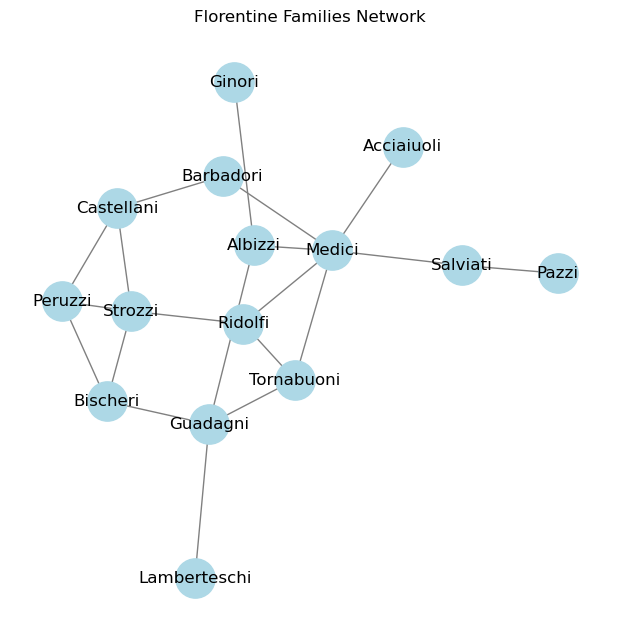

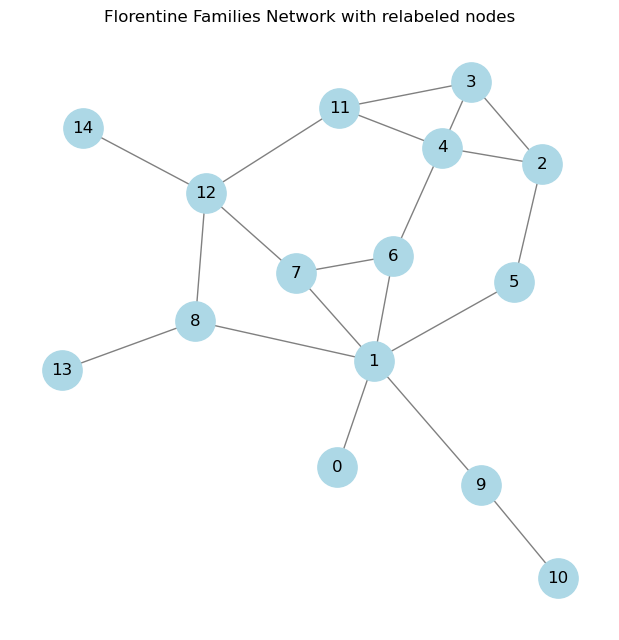

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()


G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

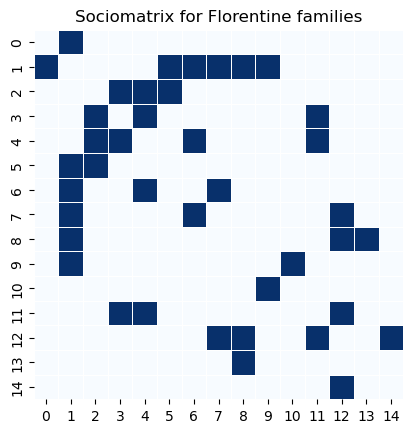

In [3]:
Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show()

# Latent space

In [4]:
import plotly.express as px


n = len(G.nodes)
Z = np.random.randn(n, 3)
df = pd.DataFrame(Z, columns=['x', 'y', 'z'])
df['node'] = list(G.nodes)

fig = px.scatter_3d(df, x='x', y='y', z='z', text='node', opacity=0.7)
fig.update_layout(title='Initialization of latent variables')
fig.show()

## Searching MLE

Loglikelihood: -0.19875304551444564


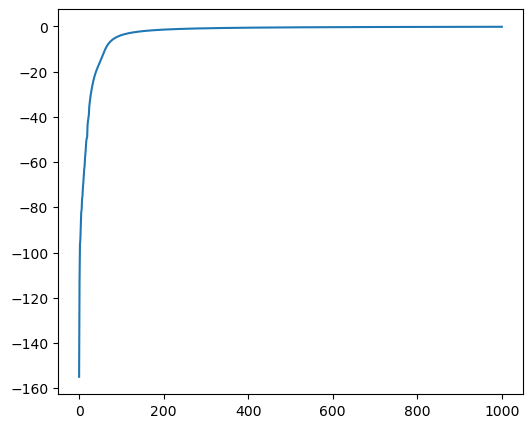

In [5]:
Z_ML, a_ML, historyZ, historya  =  SearchingMLE(G, np.random.randn(n, 3),np.random.randn(),1000)
Z_ML = Z_ML - np.mean(Z_ML, axis=0)

print("Loglikelihood:", loglikelihood(G, Z_ML,a_ML))

fig, ax = plt.subplots(figsize = (6,5))
ax.plot([loglikelihood(G, historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = list(G.nodes)

fig = px.scatter_3d(df, x='x', y='y', z='z', text='node', opacity=0.7)
fig.update_layout(title='Latent variables: MLE')
fig.show()

## Sociomatrix

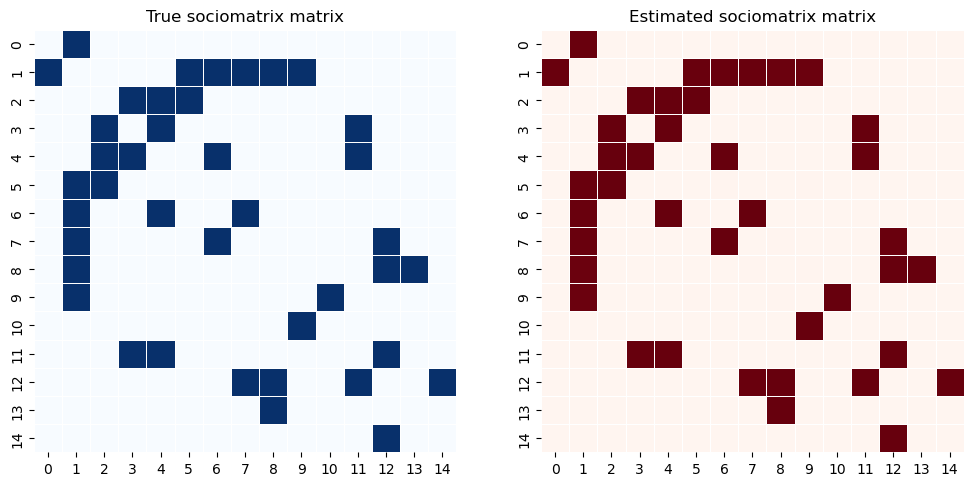

In [6]:
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_ML[i,j] = expit(a_ML - 0.5 * np.linalg.norm(Z_ML[i] - Z_ML[j])**2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

# Applying Hamiltonian Monte Carlo Algorithm

In [33]:
# Execute HMC
number_of_samples = 2500
Z_init = np.random.randn(Z_ML.shape[0],Z_ML.shape[1])
a_init = np.random.randn(1)

print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init)[0])

samples_Z, samples_a, Hp, LogLp, acep_rate_history = hmc(G, Z_init, a_init, number_of_samples, epsilon_init=0.1, std_dev=1.0, percentage_warmup=0.2, Z0 = Z_ML)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM))

Log-L MLE: -0.19875304551444564
Log-L starter: -128.64921657202217
Number of samples: 2500
Number of parameters: 16
Number of iterations: 3000
Number of warmup iterations: 500


 17%|█▋        | 500/3000 [03:15<15:42,  2.65it/s]

Final parameters: epsilon=0.0500, L=20, std_dev=0.0500


100%|██████████| 3000/3000 [18:47<00:00,  2.66it/s]

Acceptance rate: 0.06604
Log-L MAP: -47.00762211544817
Log-L CM: -48.30648904482528


In [34]:
#plot_Z_samples_3D(samples_Z)

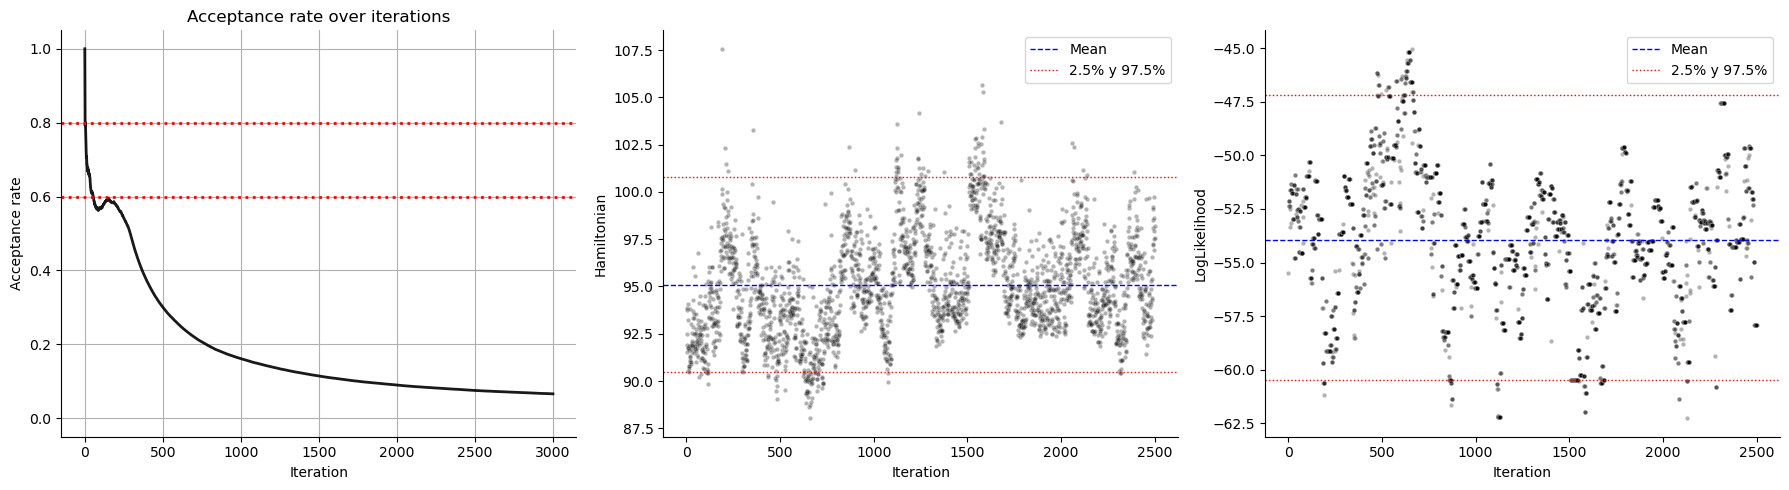

In [35]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

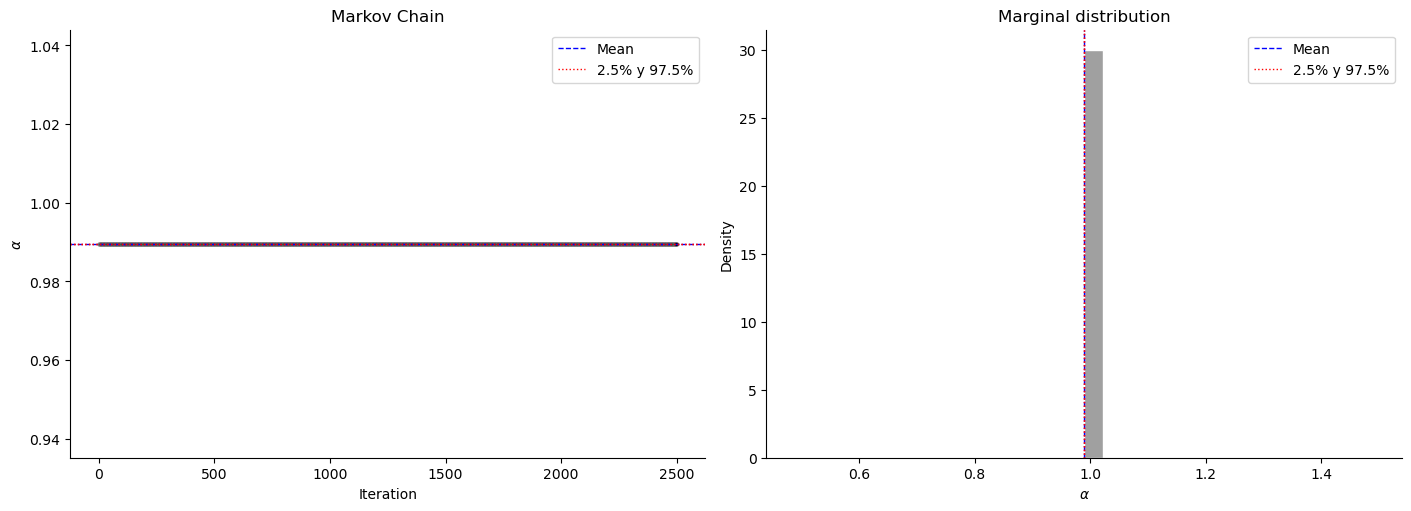

In [36]:
plot_alpha(samples_a)

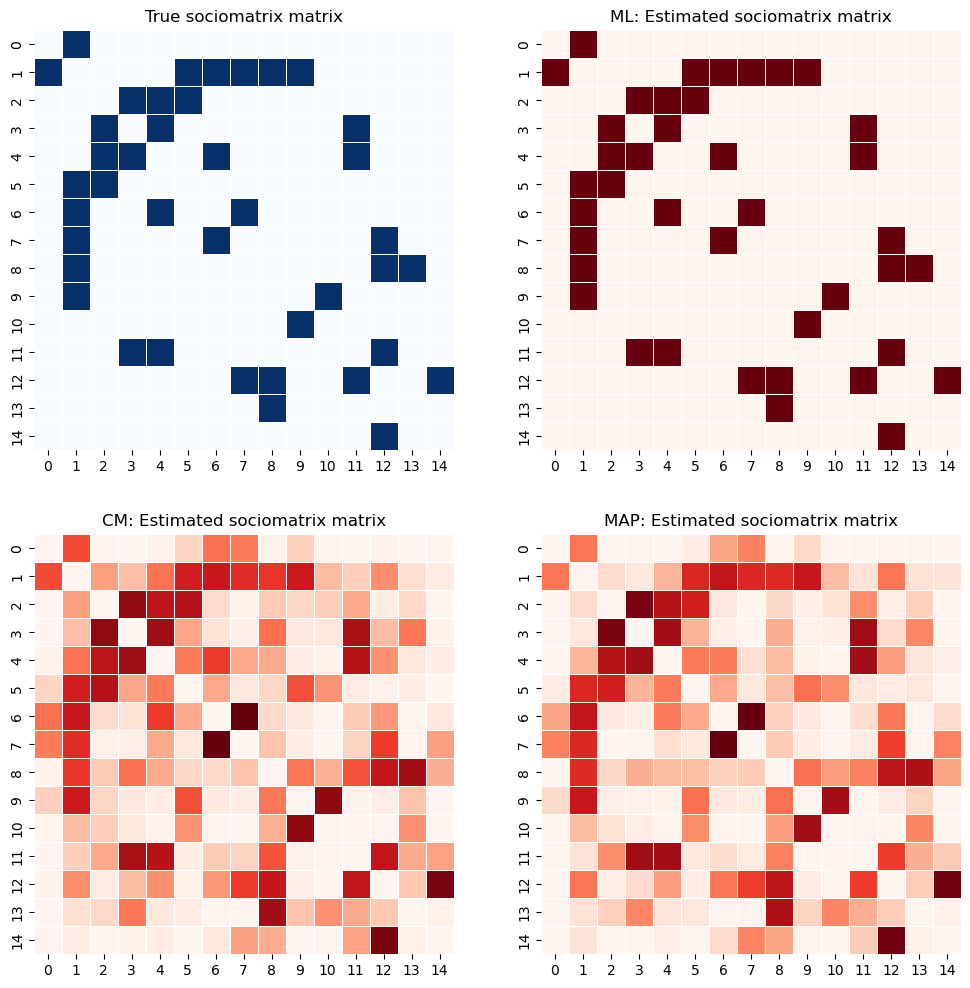

In [37]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM[i,j] = expit(a_CM - 0.5 * np.linalg.norm(Z_CM[i] - Z_CM[j])**2)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP[i,j] = expit(a_MAP - 0.5 * np.linalg.norm(Z_MAP[i] - Z_MAP[j])**2)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

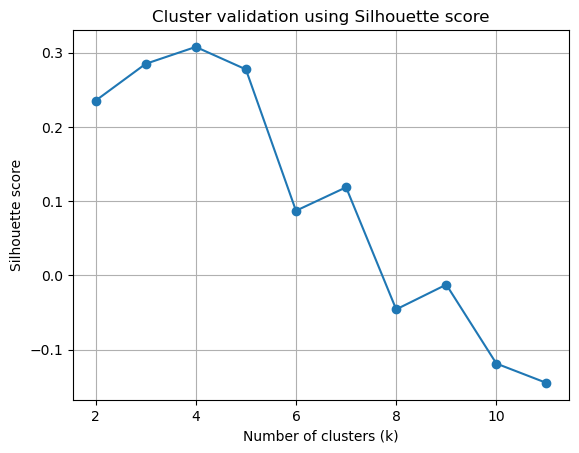

Best number of clusters: 4


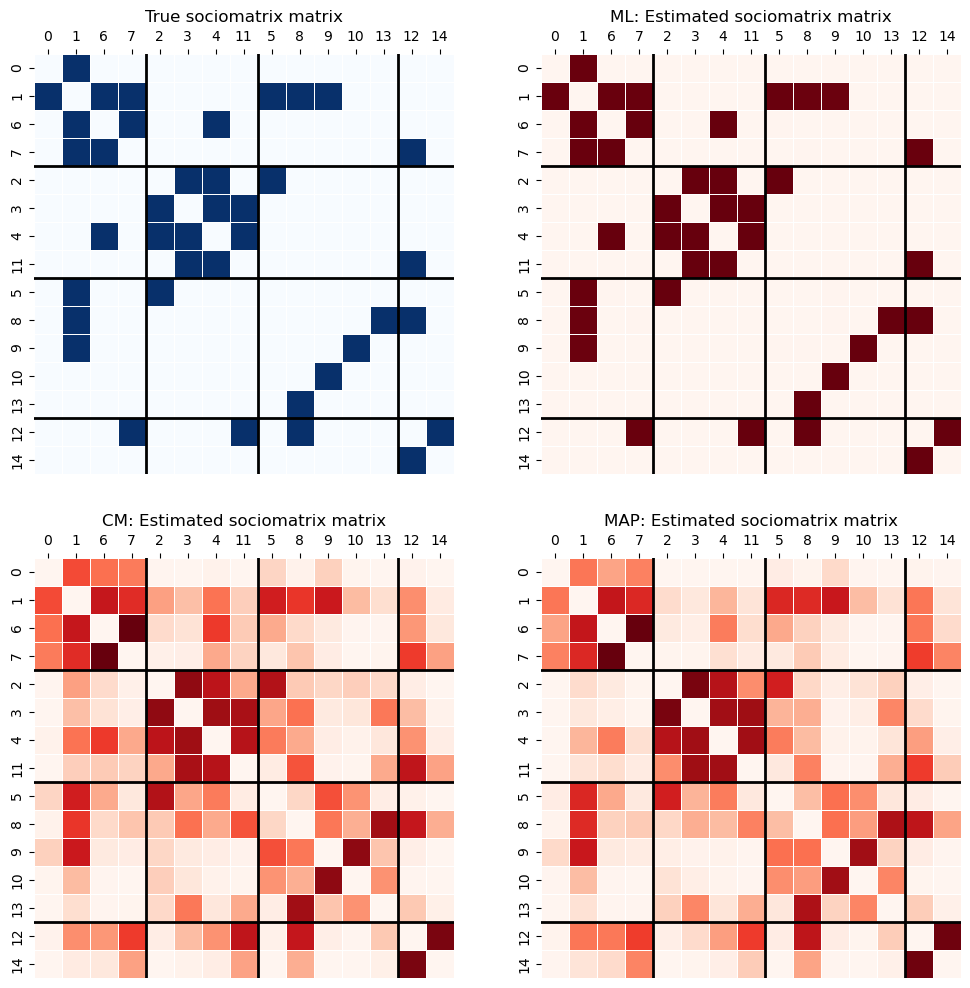

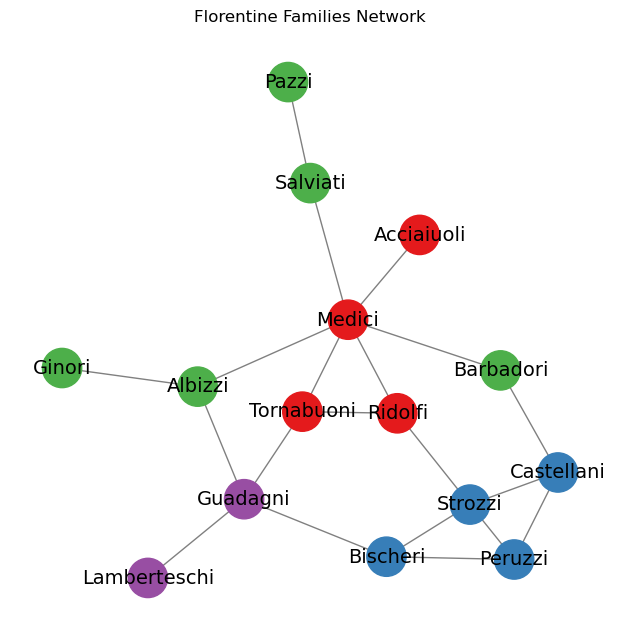

In [38]:
clustering3D(G,node_mapping, Z_ML, a_ML, Z_MAP, a_MAP, Z_CM, a_CM)

# Model checking

## Posterior predictive checking

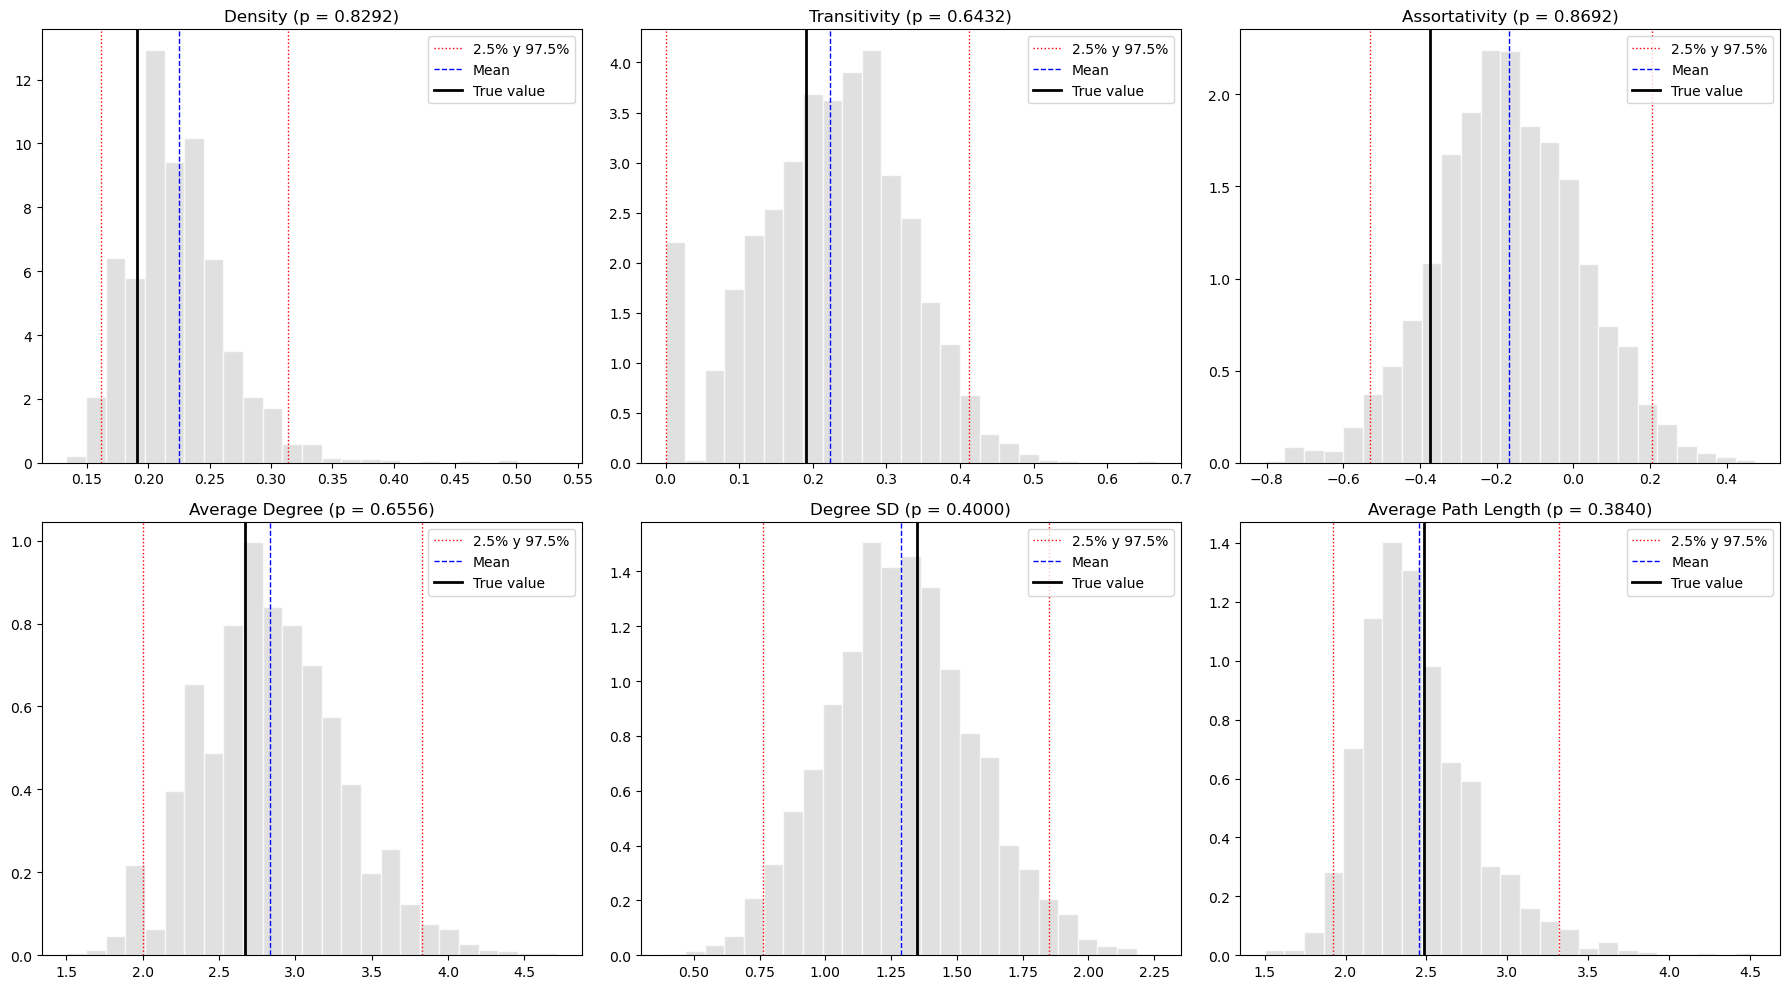

In [39]:
predictive_check(G,samples_Z,samples_a)

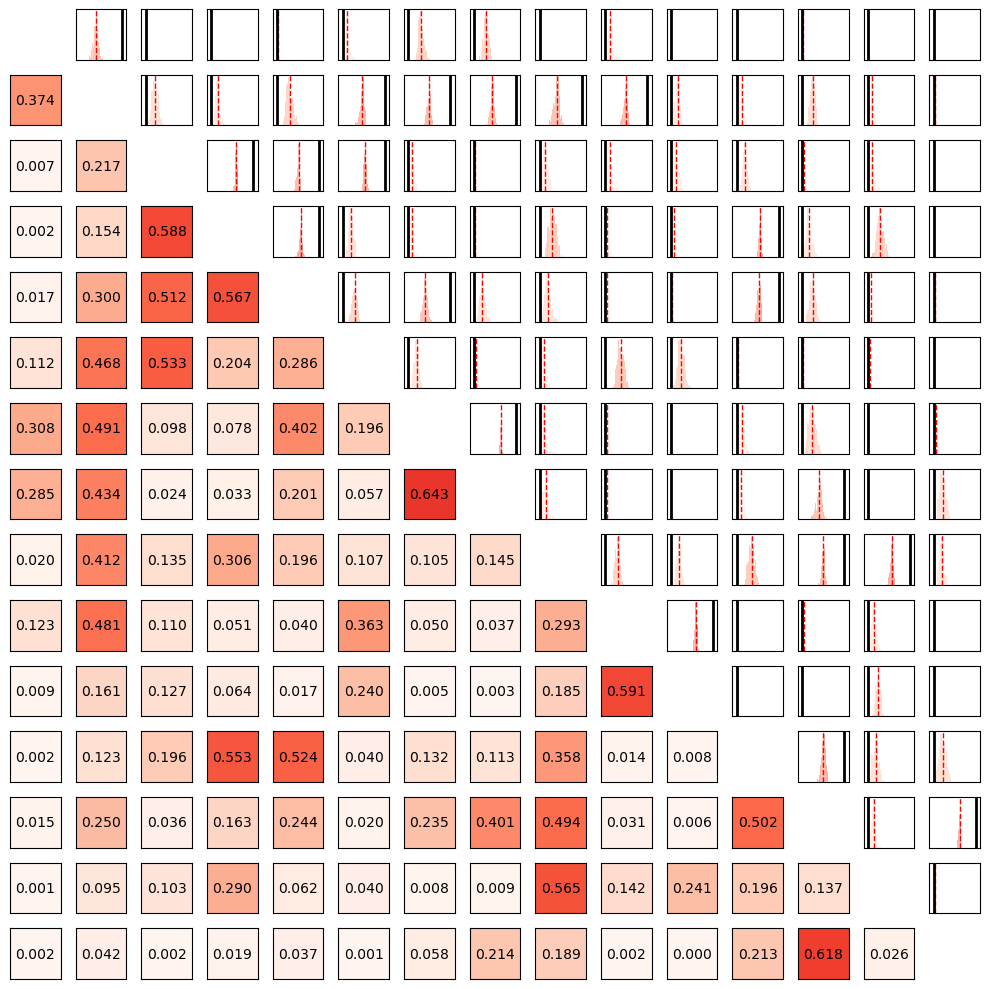

In [40]:
plot_pairwise_sociomatrix(G,samples_Z, samples_a, Y)

## Model comparison criteria

In [41]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a)
waic = compute_WAIC(log_lik)
dic = compute_DIC(log_lik, Y, samples_Z, samples_a)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")


WAIC: 100.2014
DIC: 101.7370


## Prior predictive checks

c:\Users\carlo\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning:

invalid value encountered in scalar divide



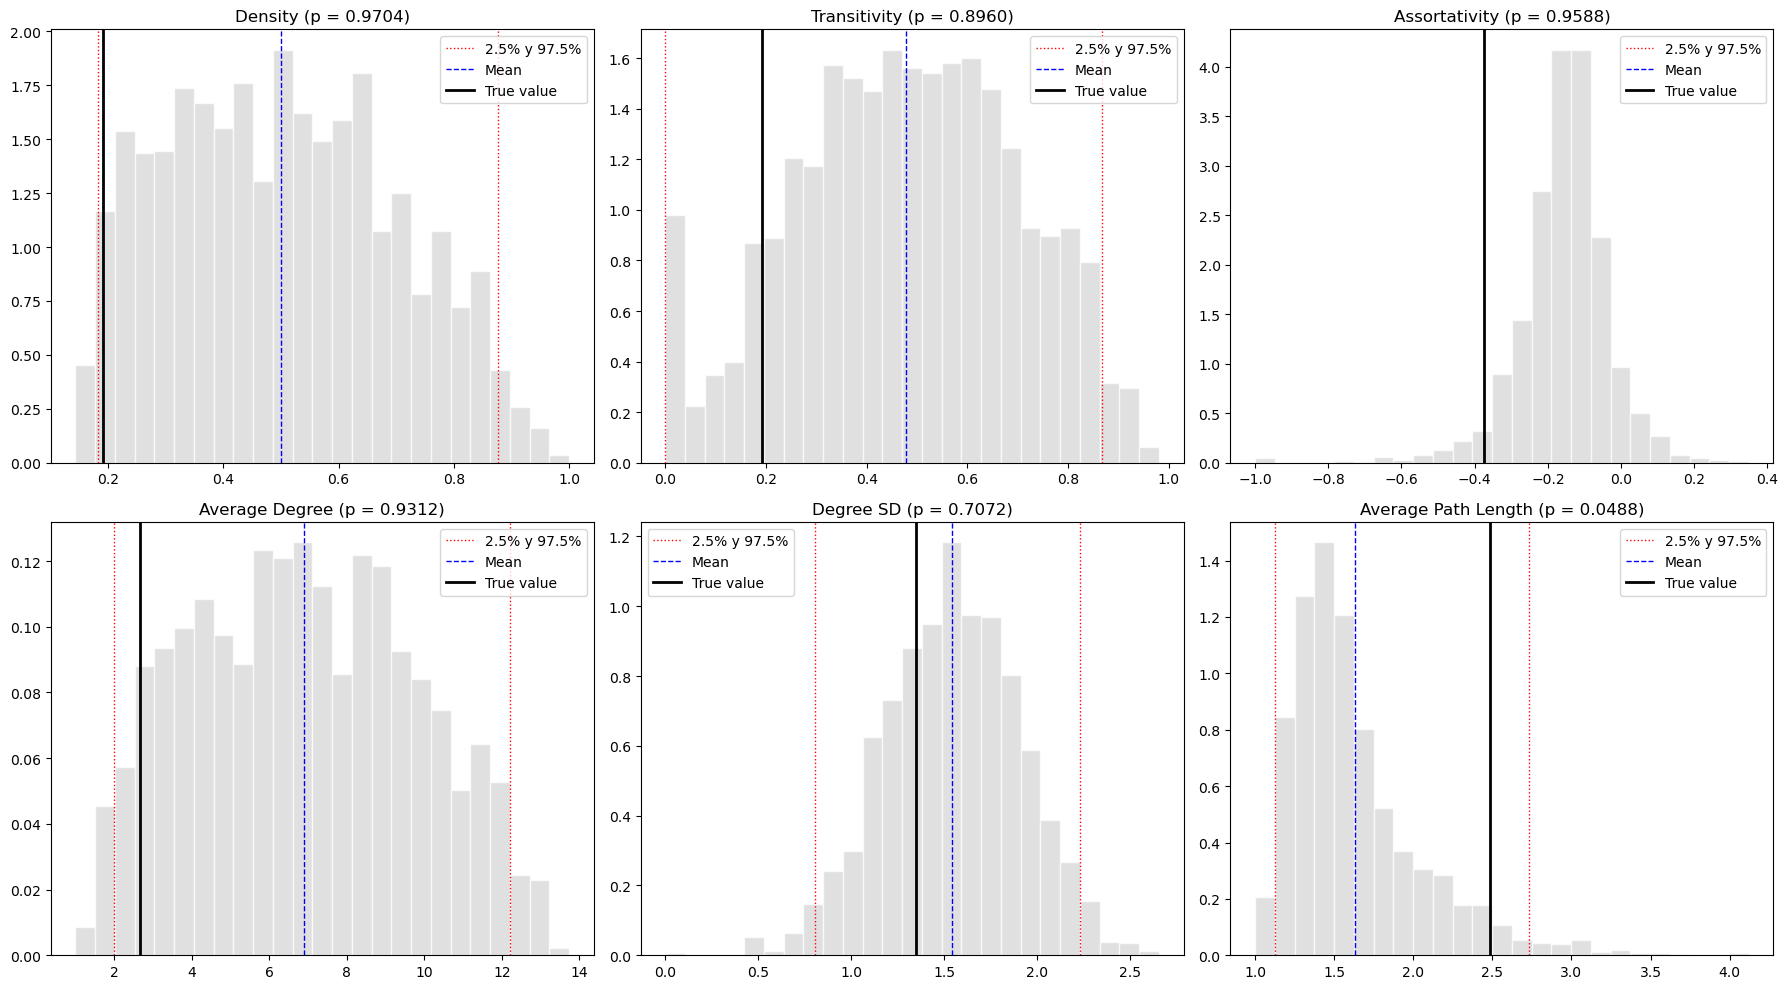

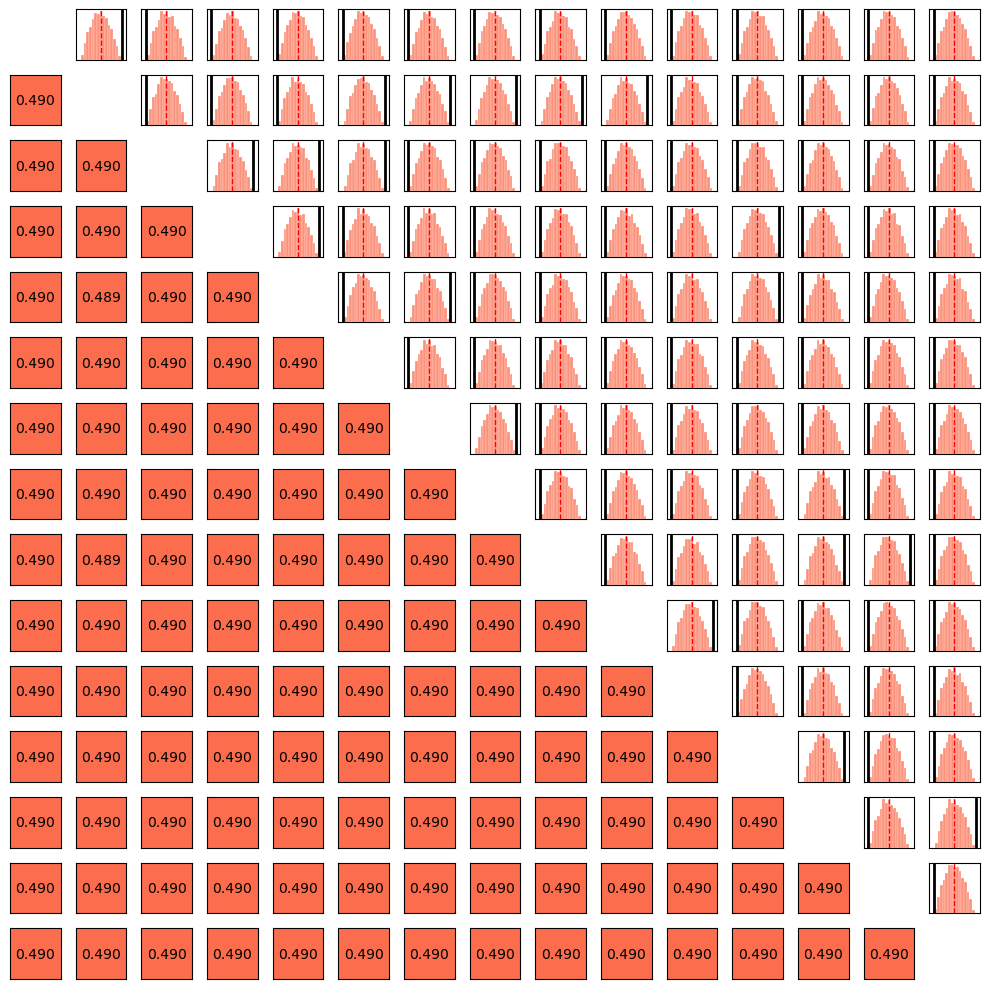

WAIC: 389.2187
DIC: 368.5367


In [42]:
samples_Z_prior = 0.1*np.random.randn(number_of_samples, n, 2)
samples_a_prior = np.random.randn(number_of_samples)

predictive_check(G,samples_Z_prior,samples_a_prior)

plot_pairwise_sociomatrix(G,samples_Z_prior, samples_a_prior, Y)

log_lik_prior = compute_log_likelihood(Y_ML, samples_Z_prior, samples_a_prior)
waic_prior = compute_WAIC(log_lik_prior)
dic_prior = compute_DIC(log_lik_prior, Y_ML, samples_Z_prior, samples_a_prior)


print(f"WAIC: {waic_prior:.4f}")
print(f"DIC: {dic_prior:.4f}")

## Residual analysis

In [43]:
residuals = residual_analysis(Y, samples_Z, samples_a)
residuals_dict = residual_distributions(Y, samples_Z, samples_a)
plot_residual_distributions(residuals_dict, n)
residual_summary = summarize_residuals_bayesian(residuals_dict)


summary_matrices = analyze_residuals_matrix(residuals_dict, Y_ML.shape[0])
plot_residual_summary_matrices(summary_matrices)

KeyboardInterrupt: 

## Prediction evaluation

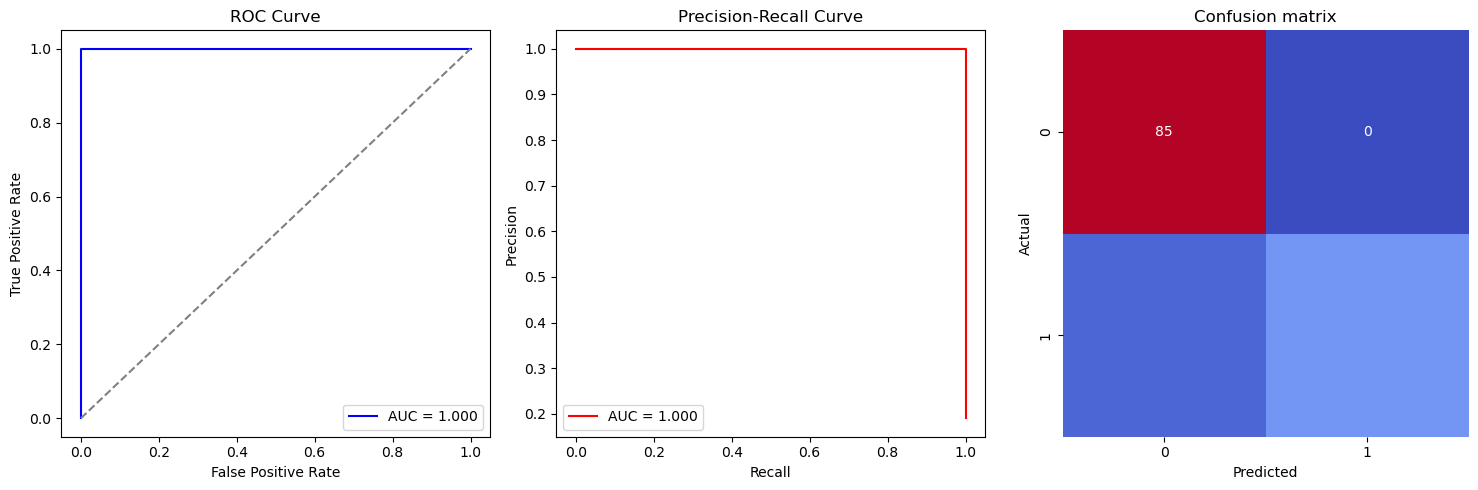

In [ ]:
prob_mean = posterior_connection_probs(samples_Z, samples_a)
metrics = roc_prc_analysis(Y, prob_mean)

## Community checking

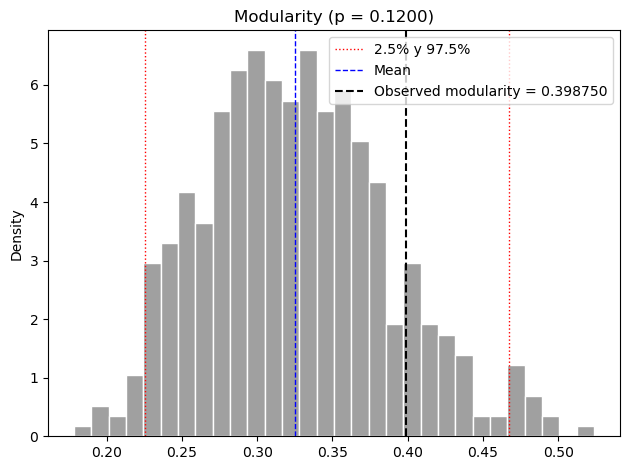

In [ ]:
mod_obs, mod_sim = modularity_check(Y, samples_Z, samples_a)